# Power Laws: Forecasting Energy Consumption

https://www.drivendata.org/competitions/51/electricity-prediction-machine-learning/

This challenge is one of three challenges in the “Power Laws” series being run simultaneoulsy by Schneider Electric. Each challenge explores a different aspect of energy efficiency and smart energy management.

# My aproach

This challenge was about predicting the energy consumption for a particular site. You are given historical data at this location and also weather data taken from nearby weather stations.

The difficulty here is that the training and test set overlap.
Some test data are in the past compared to some training data and the competition description is really clear about that: no future consumption data can be used for the prediction. This makes sense but it makes the use of a generic timeserie algorithm trickier to use.

My approach was to run a KNN for each site using historical data from this site combined with the weather data.

This simple approach ranked 40 in the drivendata.org competition. Not bad for this simple solution.

Note: All the code here is mine

# Some data wrangling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline  

from fastai.structured import *
from fastai.column_data import *

import pandas as pd
import numpy as np
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot

import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.display import HTML

In [108]:
%ls

data/                        out/
fastai@                      power law consumption.ipynb
myconcat


In [13]:
train = pd.read_csv('data/train.csv')

In [14]:
test = pd.read_csv('data/submission_format.csv')
weather = pd.read_csv('data/weather.csv') # extrapolate the data to get rid of NaN values
meta = pd.read_csv('data/metadata.csv') # is it really needed? if we're predicting based on SiteId... not really
holidays = pd.read_csv('data/holidays.csv')
# holidays has an unnamed index, we remove it
del holidays['Unnamed: 0']
freq = pd.read_csv('data/submission_frequency.csv')

In [15]:
# convert date fields to actual datetime objects
holidays['Date'] = pd.to_datetime(holidays['Date']).dt.date
train['Date'] = pd.to_datetime(train['Timestamp']).dt.date
test['Date'] = pd.to_datetime(test['Timestamp']).dt.date

In [16]:
# add the holidays info to the training and test sets
train = train.merge(holidays, how='left', on=['SiteId', 'Date'])
test = test.merge(holidays, how='left', on=['SiteId', 'Date'])

In [21]:
# add the meta data info to the training and test sets
train = train.merge(meta, how='left', on='SiteId')
test = test.merge(meta, how='left', on='SiteId')

# Sampling indicates the method of time sampling but
# since the prediction is done per site & sampling, the information is not necessary
del train['Sampling']
del test['Sampling']

In [19]:
# we add a column to indicate if date is a holiday or not
train.loc[train.Holiday.notna(), "Holiday"] = 1
train.loc[train.Holiday.isnull(), "Holiday"] = 0

test.loc[test.Holiday.notna(), "Holiday"] = 1
test.loc[test.Holiday.isnull(), "Holiday"] = 0

In [22]:
Off = [x for x in train.columns.values if 'IsDayOff' in x]
Off

['MondayIsDayOff',
 'TuesdayIsDayOff',
 'WednesdayIsDayOff',
 'ThursdayIsDayOff',
 'FridayIsDayOff',
 'SaturdayIsDayOff',
 'SundayIsDayOff']

In [24]:
# Let's convert these boolean values to integers
for x in Off:
    train[x] = train[x].astype(int)
    test[x] = test[x].astype(int)

In [25]:
# add the day of the week
train['dow'] = pd.to_datetime(train['Date']).dt.dayofweek
test['dow'] = pd.to_datetime(test['Date']).dt.dayofweek

In [26]:
# add minutes & month
train['minutes'] = pd.to_datetime(train['Timestamp']).dt.hour * 60 + pd.to_datetime(train['Timestamp']).dt.minute
test['minutes'] = pd.to_datetime(test['Timestamp']).dt.hour * 60 + pd.to_datetime(test['Timestamp']).dt.minute
train['month'] = pd.to_datetime(train['Timestamp']).dt.month
test['month'] = pd.to_datetime(test['Timestamp']).dt.month
train.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,Date,Holiday,Surface,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,dow,minutes,month
0,744519,1,2014-09-03 00:00:00,1,9.096555e+05,2014-09-03,0,1387.205119,18.0,0,0,0,0,0,1,1,2,0,9
1,7627564,1,2014-09-04 00:00:00,1,1.748273e+06,2014-09-04,0,1387.205119,18.0,0,0,0,0,0,1,1,3,0,9
2,7034705,1,2014-09-05 00:00:00,1,NaN,2014-09-05,0,1387.205119,18.0,0,0,0,0,0,1,1,4,0,9
3,5995486,1,2014-09-06 00:00:00,1,NaN,2014-09-06,0,1387.205119,18.0,0,0,0,0,0,1,1,5,0,9
4,7326510,1,2014-09-07 00:00:00,1,NaN,2014-09-07,0,1387.205119,18.0,0,0,0,0,0,1,1,6,0,9


In [36]:
# the weather data holds temperature records from weather stations near the power plant
# to keep it simple when merging with train & test, we'll make the weather data unique 
# for each SiteId and Timestamp by taking the median value
weather_unique = weather.groupby(['SiteId', 'Timestamp'], as_index=False).agg(np.median)

## Missing values

In [63]:
print("There is %.1f%% missing values" % (100 * (len(Xw[Xw.Value.isnull()]) / len(Xw))))

There is 1.3% missing values


In [64]:
# merge with weather and sort the training and test sets
train = train.merge(weather_unique, how='left', on=['SiteId', 'Timestamp'])
train.sort_values(['SiteId', 'ForecastId', 'Timestamp'], inplace=True)

test = test.merge(weather_unique, how='left', on=['SiteId', 'Timestamp'])
test.sort_values(['SiteId', 'ForecastId', 'Timestamp'], inplace=True)

In [ ]:
# to handle missing training Values, I tested 2 methods:
# _ get rid of the lines with missing values
# _ since we sorted the training set and the missing values are we just forward fill the data:
#    train = train.fillna(method='ffill')
# _ we could have deducted missing values from the prediction algo done at the end

In [69]:
train = train[train.Value.isnull() == False]

## Outliers
It seems there are some Value outliers. 
They seem completelly wrong, they are probably issues with the measures and could be safely removed.
6.40468e+11 is the max value... when the 75 percentile is 46514... that's a clear outlier

In [112]:
display(DataFrameSummary(train).summary())

,obs_id,SiteId,Timestamp,ForecastId,Value,Date,Holiday,Surface,BaseTemperature,MondayIsDayOff,...,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,dow,minutes,month,Unnamed: 0,Temperature,Distance
count,6.47697e+06,6.47697e+06,NaN,6.47697e+06,6.47697e+06,NaN,6.47697e+06,6.47697e+06,6.47697e+06,6.47697e+06,...,6.47697e+06,6.47697e+06,6.47697e+06,6.47697e+06,6.47697e+06,6.47697e+06,6.47697e+06,1.13931e+06,1.13931e+06,1.13931e+06
mean,3.93512e+06,162.155,NaN,3483.08,356124,NaN,0.024129,9222.22,18.0071,0,...,0,0.00866701,0.973954,0.976997,2.99965,707.057,6.47355,65662.1,14.3775,14.9065
std,2.27149e+06,93.8294,NaN,2007.64,3.3085e+08,NaN,0.15345,10581.7,0.120948,0,...,0,0.0926925,0.159273,0.149911,1.99841,418.721,3.38822,63789.9,7.90351,7.9581
min,0,1,NaN,1,0,NaN,0,14.8845,18,0,...,0,0,0,0,0,0,1,0,-19.55,1.29867
25%,1.96813e+06,87,NaN,1749,3491.63,NaN,0,1334.98,18,0,...,0,0,1,1,1,345,4,22712.9,9,8.15598
50%,3.93527e+06,173,NaN,3490,14085.4,NaN,0,5802.69,18,0,...,0,0,1,1,3,705,7,46463,14.8,12.1383
75%,5.90204e+06,237,NaN,5212,46514,NaN,0,14588.8,18,0,...,0,0,1,1,5,1065,9,83851,20,21.6009
max,7.86900e+06,305,NaN,6974,6.40468e+11,NaN,1,71615.9,21,0,...,0,1,1,1,6,1435,12,294611,41.95,29.9778
counts,6476973,6476973,6476973,6476973,6476973,6476973,6476973,6476973,6476973,6476973,...,6476973,6476973,6476973,6476973,6476973,6476973,6476973,1139308,1139308,1139308
uniques,6473229,267,595534,6964,1933565,2931,2,267,3,1,...,1,2,2,2,7,385,12,284084,1619,367


# Prediction
For each of the 6974 ForecastIDs (1 SiteID / 1 Sampling), we use KNN (with 4 neighbors) to predict the power consumption


For this simple approach, we'll keep only columns that guarantee we are within the rules 
 (no use of future data) - I had some doubts for example about using the month

In [72]:
cols = ['ForecastId', 'Holiday', 'dow', 'minutes', 'Temperature', 'Distance', 'Value']

In [ ]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

# Loop over the ForecastIds
for x in range(6975):

    # Select training and test sets for this particular ForecastId
    X = train[train.ForecastId == x]
    Y = test[test.ForecastId == x]
    
    print(x, len(X), len(Y))
    
    if len(X) == 0:
        pass

    else:

        # Extract normalized dataframe to run KNN (data needs to be normalized for KNN)
        # proc_df is a convenient function from fastai, basically a scaler
        df, y, nas, mapper = proc_df(X[cols], 'Value', do_scale=True)
        
        # Apply same normalized operation to the test set
        df_test, _, nas, mapper = proc_df(Y[cols], 'Value', do_scale=True, mapper=mapper, na_dict=nas)
        
        # Fit the model
        model.fit(df, np.log1p(y))

        # Predict
        test.loc[test.ForecastId == x, "Value"] = np.expm1(model.predict(df_test))


In [77]:
train.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,Date,Holiday,Surface,BaseTemperature,MondayIsDayOff,...,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,dow,minutes,month,Unnamed: 0,Temperature,Distance
0,744519,1,2014-09-03 00:00:00,1,9.096555e+05,2014-09-03,0,1387.205119,18.0,0,...,0,0,1,1,2,0,9,90323.5,19.60,22.921092
1,7627564,1,2014-09-04 00:00:00,1,1.748273e+06,2014-09-04,0,1387.205119,18.0,0,...,0,0,1,1,3,0,9,90349.0,21.30,22.921092
5,3625268,1,2014-09-08 00:00:00,1,1.964878e+06,2014-09-08,0,1387.205119,18.0,0,...,0,0,1,1,0,0,9,90451.0,15.25,22.921092
6,6038546,1,2014-09-09 00:00:00,1,3.266904e+06,2014-09-09,0,1387.205119,18.0,0,...,0,0,1,1,1,0,9,90477.0,19.15,22.921092
7,4114748,1,2014-09-10 00:00:00,1,2.926094e+06,2014-09-10,0,1387.205119,18.0,0,...,0,0,1,1,2,0,9,90503.0,19.25,22.921092


In [82]:
train.Value.describe()

count    6.476973e+06
mean     3.561242e+05
std      3.308498e+08
min      0.000000e+00
25%      3.491627e+03
50%      1.408543e+04
75%      4.651404e+04
max      6.404683e+11
Name: Value, dtype: float64

In [83]:
np.percentile(train.Value, 90)

119680.04098452491

In [90]:
len(train[train.Date < datetime.date(2014,1,1)]), len(train)

(416111, 6476973)

# How well are we doing?

This solution placed 40 on the leaderboard, not bad for a simple approach!

To visualize the predictions, we plot the training and predicted value for 9 of the forecast id

Some are doing extremmly well (last 3 graphs for example)

Some should be used for deeper investigation (number 4 for example)

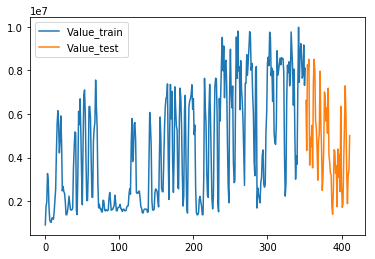

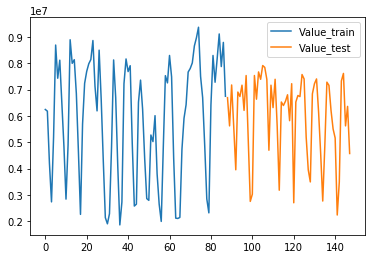

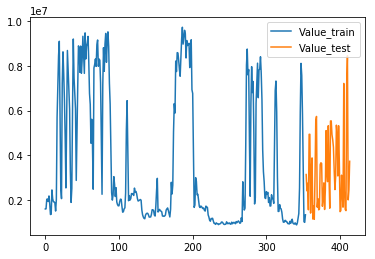

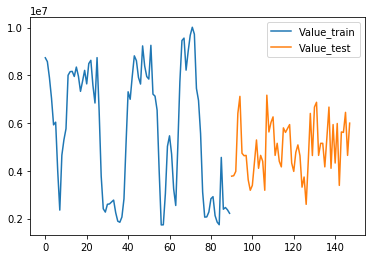

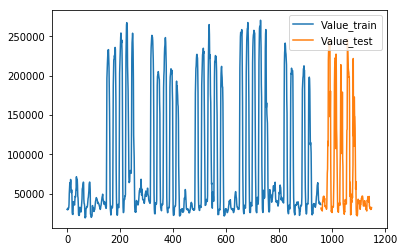

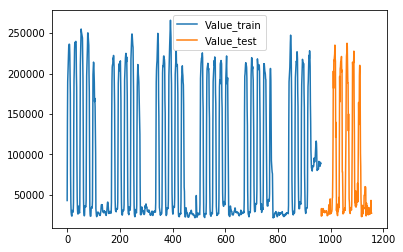

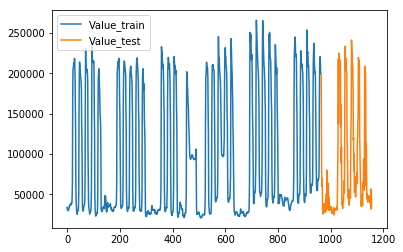

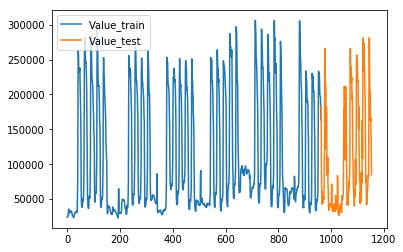

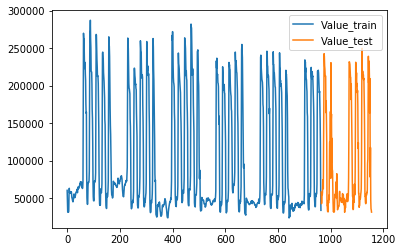

In [132]:
for forid in range(1, 10):
    res = train[train.ForecastId == forid][['Timestamp', 'Value']].merge(test[test.ForecastId == forid][['Timestamp', 'Value']],
                                      on='Timestamp', how='outer', suffixes=('_train', '_test'))
    res.plot()

# File submission

In [ ]:
full_test = full_test.merge(test[['obs_id','SiteId','Timestamp','ForecastId', 'Value']], how='left', 
                on=['obs_id','SiteId','Timestamp','ForecastId'],
               suffixes=('_to_remove', ''))

In [108]:
del full_test['Value_to_remove']

In [110]:
full_test.sort_values(['SiteId', 'ForecastId', 'Timestamp'], inplace=True)
full_test.fillna(method='ffill', inplace=True)

In [114]:
full_final = full_test.groupby(['obs_id', 'SiteId', 'ForecastId', 'Timestamp'], as_index=False).agg(np.median)

In [130]:
format_file = pd.read_csv('data/submission_format.csv')

In [131]:
wrong = full_final.set_index('obs_id')
correct=wrong.reindex(index=format_file.obs_id)
correct.reset_index(inplace=True)
correct[['obs_id','SiteId','Timestamp','ForecastId','Value']].to_csv('knn_reorder.csv', index=False)